# Оптимизация процесса восстановления золота из руды

Целью проекта является анализ данных технологических процессов золотодобывающей компании и построение модели предсказания эффективности добычи золота. 

## Данные
Данные находятся в трёх файлах:

**gold_industry_train.csv** — обучающая выборка;

**gold_industry_test.csv** — тестовая выборка;

**gold_industry_full.csv** — исходные данные.

Данные индексируются датой и временем получения информации (признак date). Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

### Технологический процесс

**Rougher feed** — исходное сырье

**Rougher additions** (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant

**Xanthate** — ксантогенат (промотер, или активатор флотации);

**Sulphate** — сульфат (на данном производстве сульфид натрия);

**Depressant** — депрессант (силикат натрия).

**Rougher process** (англ. «грубый процесс») — флотация

**Rougher tails** — отвальные хвосты

**Float banks** — флотационная установка

**Cleaner process** — очистка

**Rougher Au** — черновой концентрат золота

**Final Au** — финальный концентрат золота


### Параметры этапов

air amount — объём воздуха

fluid levels — уровень жидкости

feed size — размер гранул сырья

feed rate — скорость подачи

### Наименование признаков

Структура наименования признаков:

**[этап].[тип_параметра].[название_параметра]**

Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:

rougher — флотация

primary_cleaner — первичная очистка

secondary_cleaner — вторичная очистка

final — финальные характеристики

Возможные значения для блока [тип_параметра]:

input — параметры сырья

output — параметры продукта

state — параметры, характеризующие текущее состояние этапа

calculation — расчётные характеристики

## Метрика

Эффективность обогащения расчитываем по формуле:

$$
\text{Recovery} = \frac{C \times (F - T)}{F \times (C - T)} \times 100
$$

В качестве метрики используем sMAPE:

$$
\text{sMAPE} = \frac{1}{n} \sum_{i=1}^{n} \frac{|F_i - A_i|}{\left( |A_i| + |F_i| \right) / 2} \times 100
$$

## План исследования

1. Подготовка данных

    1.1. Загрузка необходимых библиотек
    
    1.2. Открываем и изучаем каждый предоставленный датафрейм
    
    1.3. Проверка корректности рассчета эффективности восстановления золота

<p style="line-height:1em;"></p>
    
2. Анализ данных

<p style="line-height:1em;"></p>

3. Применение моделей

<p style="line-height:1em;"></p>

4. Выбор модели для оптимизации

<p style="line-height:1em;"></p>

5. Оптимизация модели, проверка на тестовой выборке, сравнение с dummy моделью 


## Подготовка данных

### Загрузка библиотек

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error, make_scorer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor, BayesianRidge, ElasticNet
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, cross_val_score

Все необходимые библиотеки загружены

### Загрузка и проверка данных

In [2]:
try:
    data_train = pd.read_csv('gold_industry_train.csv')
    data_test = pd.read_csv('gold_industry_test.csv')
    data_full = pd.read_csv('gold_industry_full.csv')
except:
    data_train = pd.read_csv('gold_industry_train.csv')
    data_test = pd.read_csv('gold_industry_test.csv')
    data_full = pd.read_csv('gold_industry_full.csv')

In [3]:
data_train.head(5)

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686


In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14579 entries, 0 to 14578
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14579 non-null  object 
 1   rougher.input.feed_au                               14579 non-null  float64
 2   rougher.input.feed_ag                               14579 non-null  float64
 3   rougher.input.feed_pb                               14507 non-null  float64
 4   rougher.input.feed_sol                              14502 non-null  float64
 5   rougher.input.feed_rate                             14572 non-null  float64
 6   rougher.input.feed_size                             14478 non-null  float64
 7   rougher.input.floatbank10_sulfate                   14548 non-null  float64
 8   rougher.input.floatbank10_xanthate                  14572 non-null  float64


In [5]:
data_test.head(5)

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2017-12-09 14:59:59,4.365491,6.158718,3.875727,39.135119,555.820208,94.544358,6.146982,9.308612,1196.238112,...,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575
1,2017-12-09 15:59:59,4.362781,6.048130,3.902537,39.713906,544.731687,123.742430,6.210119,9.297709,1201.904177,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
2,2017-12-09 16:59:59,5.081681,6.082745,4.564078,37.208683,558.155110,82.610855,7.363824,9.003562,1200.826926,...,22.993827,-501.559663,20.029144,-500.000662,18.012723,-500.024764,13.016445,-500.058432,19.973767,-501.394155
3,2017-12-09 17:59:59,5.145949,6.084374,4.768124,36.808874,539.713765,77.984784,6.927072,8.955597,1199.292489,...,23.032807,-501.287889,19.977466,-500.159903,17.980463,-500.504602,12.949071,-500.009937,20.010332,-508.337973
4,2017-12-09 18:59:59,5.735249,6.165220,4.512346,37.810642,558.713584,86.434874,7.823471,7.490356,1198.005449,...,23.001911,-499.947838,20.023735,-499.713680,17.990955,-500.334769,13.007523,-499.968459,19.995999,-499.788805


In [6]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4860 entries, 0 to 4859
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        4860 non-null   object 
 1   rougher.input.feed_au                       4860 non-null   float64
 2   rougher.input.feed_ag                       4860 non-null   float64
 3   rougher.input.feed_pb                       4832 non-null   float64
 4   rougher.input.feed_sol                      4838 non-null   float64
 5   rougher.input.feed_rate                     4856 non-null   float64
 6   rougher.input.feed_size                     4816 non-null   float64
 7   rougher.input.floatbank10_sulfate           4857 non-null   float64
 8   rougher.input.floatbank10_xanthate          4859 non-null   float64
 9   rougher.state.floatbank10_a_air             4859 non-null   float64
 10  rougher.stat

In [7]:
data_full.head(5)

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686


In [8]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   rougher.input.feed_au                               19439 non-null  float64
 2   rougher.input.feed_ag                               19439 non-null  float64
 3   rougher.input.feed_pb                               19339 non-null  float64
 4   rougher.input.feed_sol                              19340 non-null  float64
 5   rougher.input.feed_rate                             19428 non-null  float64
 6   rougher.input.feed_size                             19294 non-null  float64
 7   rougher.input.floatbank10_sulfate                   19405 non-null  float64
 8   rougher.input.floatbank10_xanthate                  19431 non-null  float64


In [9]:
pd.set_option('display.max_rows', None)
data_train.isna().sum()/len(data_train)*100

date                                                  0.000000
rougher.input.feed_au                                 0.000000
rougher.input.feed_ag                                 0.000000
rougher.input.feed_pb                                 0.493861
rougher.input.feed_sol                                0.528157
rougher.input.feed_rate                               0.048014
rougher.input.feed_size                               0.692777
rougher.input.floatbank10_sulfate                     0.212635
rougher.input.floatbank10_xanthate                    0.048014
rougher.state.floatbank10_a_air                       0.000000
rougher.state.floatbank10_a_level                     0.000000
rougher.state.floatbank10_b_air                       0.000000
rougher.state.floatbank10_b_level                     0.000000
rougher.state.floatbank10_c_air                       0.000000
rougher.state.floatbank10_c_level                     0.000000
rougher.state.floatbank10_d_air                       0

### Расчет эффективности

In [10]:
C = data_train['rougher.output.concentrate_au']
F = data_train['rougher.input.feed_au']
T = data_train['rougher.output.tail_au']

data_train['rougher.output.recovery_calculated'] = (C*(F-T))*100/(F*(C-T))
data_train['rougher.output.recovery_calculated'].head(5)

0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
Name: rougher.output.recovery_calculated, dtype: float64

In [11]:
recovery_comparison = data_train['rougher.output.recovery_calculated'] - data_train['rougher.output.recovery']
recovery_comparison.describe()

count    1.457900e+04
mean    -1.355509e-16
std      1.584799e-14
min     -7.105427e-14
25%     -1.421085e-14
50%      0.000000e+00
75%      1.421085e-14
max      7.105427e-14
dtype: float64

In [12]:
comparison = mean_absolute_error(data_train['rougher.output.recovery'], data_train['rougher.output.recovery_calculated'])
comparison

1.1181885454685472e-14

**Вывод**: Расчет эффективности произведен корректно

### Признаки, недоступные в тестовой выборке

In [13]:
absent = []
for col in data_full.columns:
    if col not in data_test.columns:
        absent.append(col)
absent

['rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_au',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'secondary_cleaner.output.tail_au',
 'secondary_cleaner.output.tail_ag',
 'secondary_cleaner.output.tail_pb',
 'secondary_cleaner.output.tail_sol',
 'final.output.concentrate_au',
 'final.output.concentrate_ag',
 'final

В тестовой выборке отутствуют параметры, получаемые на выходе той или иной стадии процесса, а также значения, вычисленные на основе этих параметров. Параметры на стадии output отсутствуют в тестовой выборке, потому что их наличие приводило бы к утечке целевого параметра соответствующиего этапа. Тоже самое с calculations - результаты вычислений, если на них обучать модель, заспойлерят ей ответ. 

### Предобработка данных

Будем группировать данные для обработки по смыслу: input, state, output, calculation. Основное внимание уделим данным для input и state, потому что именно эти данные будут в обучающем наборе. 

#### Предобработка input

In [14]:
columns_input = []
for col in data_train.columns:
    if 'input' in col:
        columns_input.append(col)
columns_input

['rougher.input.feed_au',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_sol',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.xanthate']

In [15]:
data_train[columns_input].isna().sum()

rougher.input.feed_au                   0
rougher.input.feed_ag                   0
rougher.input.feed_pb                  72
rougher.input.feed_sol                 77
rougher.input.feed_rate                 7
rougher.input.feed_size               101
rougher.input.floatbank10_sulfate      31
rougher.input.floatbank10_xanthate      7
rougher.input.floatbank11_sulfate      36
rougher.input.floatbank11_xanthate    407
primary_cleaner.input.sulfate          23
primary_cleaner.input.depressant       28
primary_cleaner.input.feed_size         0
primary_cleaner.input.xanthate         61
dtype: int64

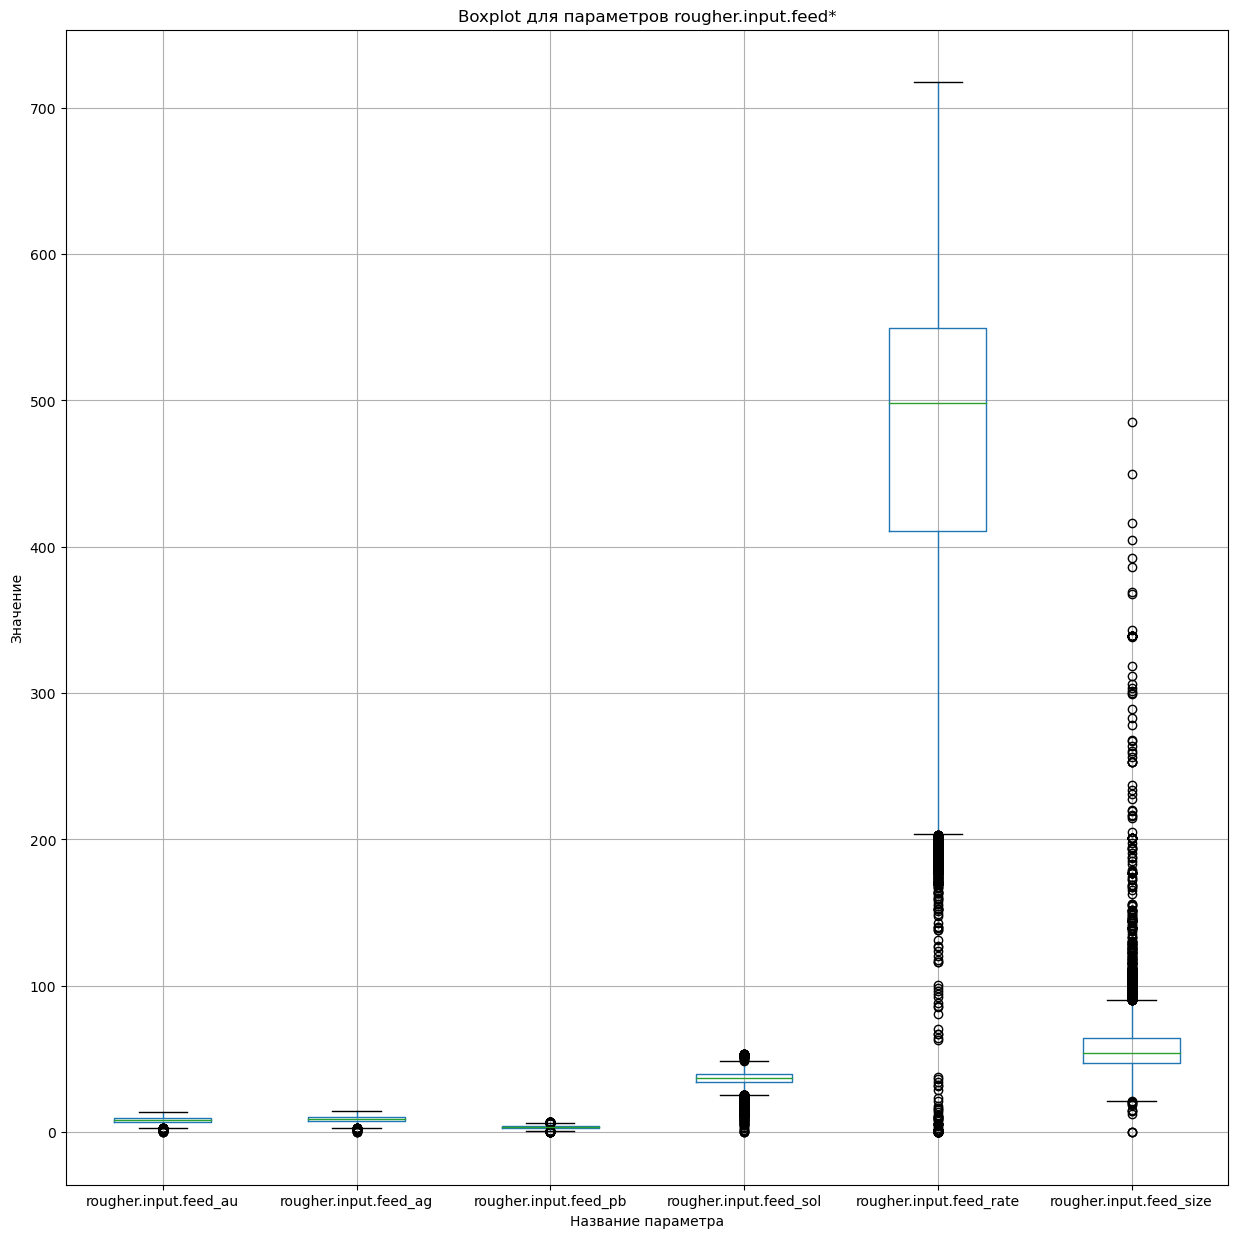

In [16]:
data_train[columns_input].filter(regex='rougher\.input\.feed').boxplot(figsize=(15,15));
plt.title('Boxplot для параметров rougher.input.feed*')
plt.xlabel('Название параметра')
plt.ylabel('Значение')
plt.show()

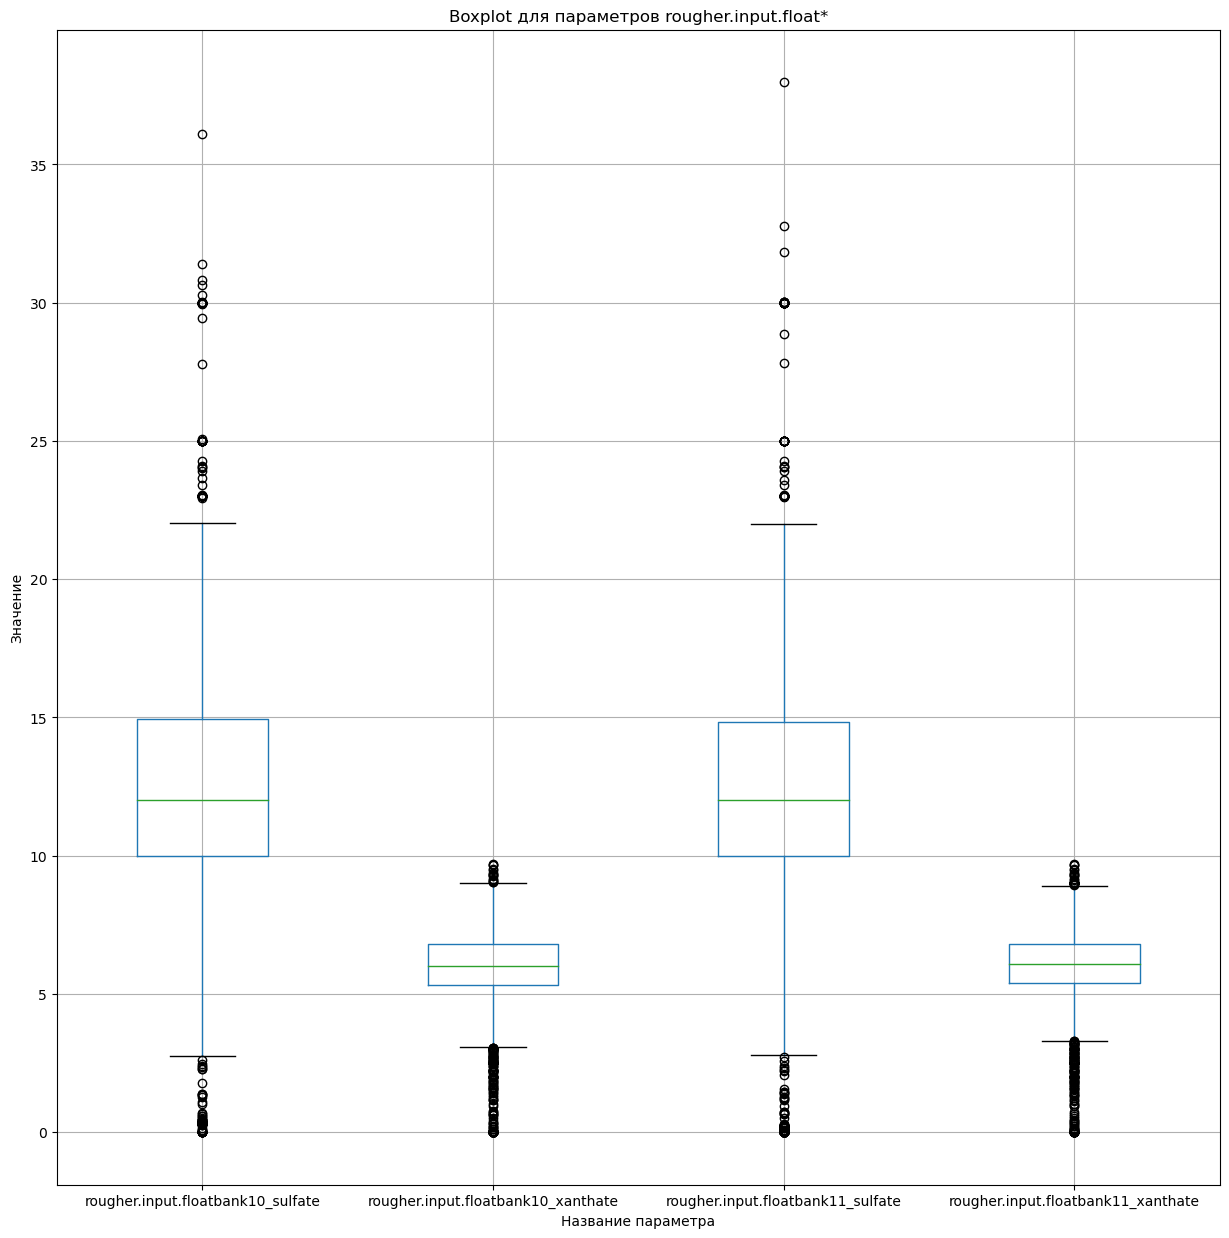

In [17]:
data_train[columns_input].filter(regex='rougher\.input\.float').boxplot(figsize=(15,15));
plt.title('Boxplot для параметров rougher.input.float*')
plt.xlabel('Название параметра')
plt.ylabel('Значение')
plt.show()

In [18]:
data_train[columns_input].filter(regex='rougher').isna().sum()/len(data_train)*100

rougher.input.feed_au                 0.000000
rougher.input.feed_ag                 0.000000
rougher.input.feed_pb                 0.493861
rougher.input.feed_sol                0.528157
rougher.input.feed_rate               0.048014
rougher.input.feed_size               0.692777
rougher.input.floatbank10_sulfate     0.212635
rougher.input.floatbank10_xanthate    0.048014
rougher.input.floatbank11_sulfate     0.246931
rougher.input.floatbank11_xanthate    2.791687
dtype: float64

 - feed_ag, feed_pb, floatbank... - параметры, отвечающие за концентрацию. Посмотрим, как они зависят от времени. Будем смотреть топ-3 по пропускам, остальных пропусков совсем мало, можно будет удалить. 

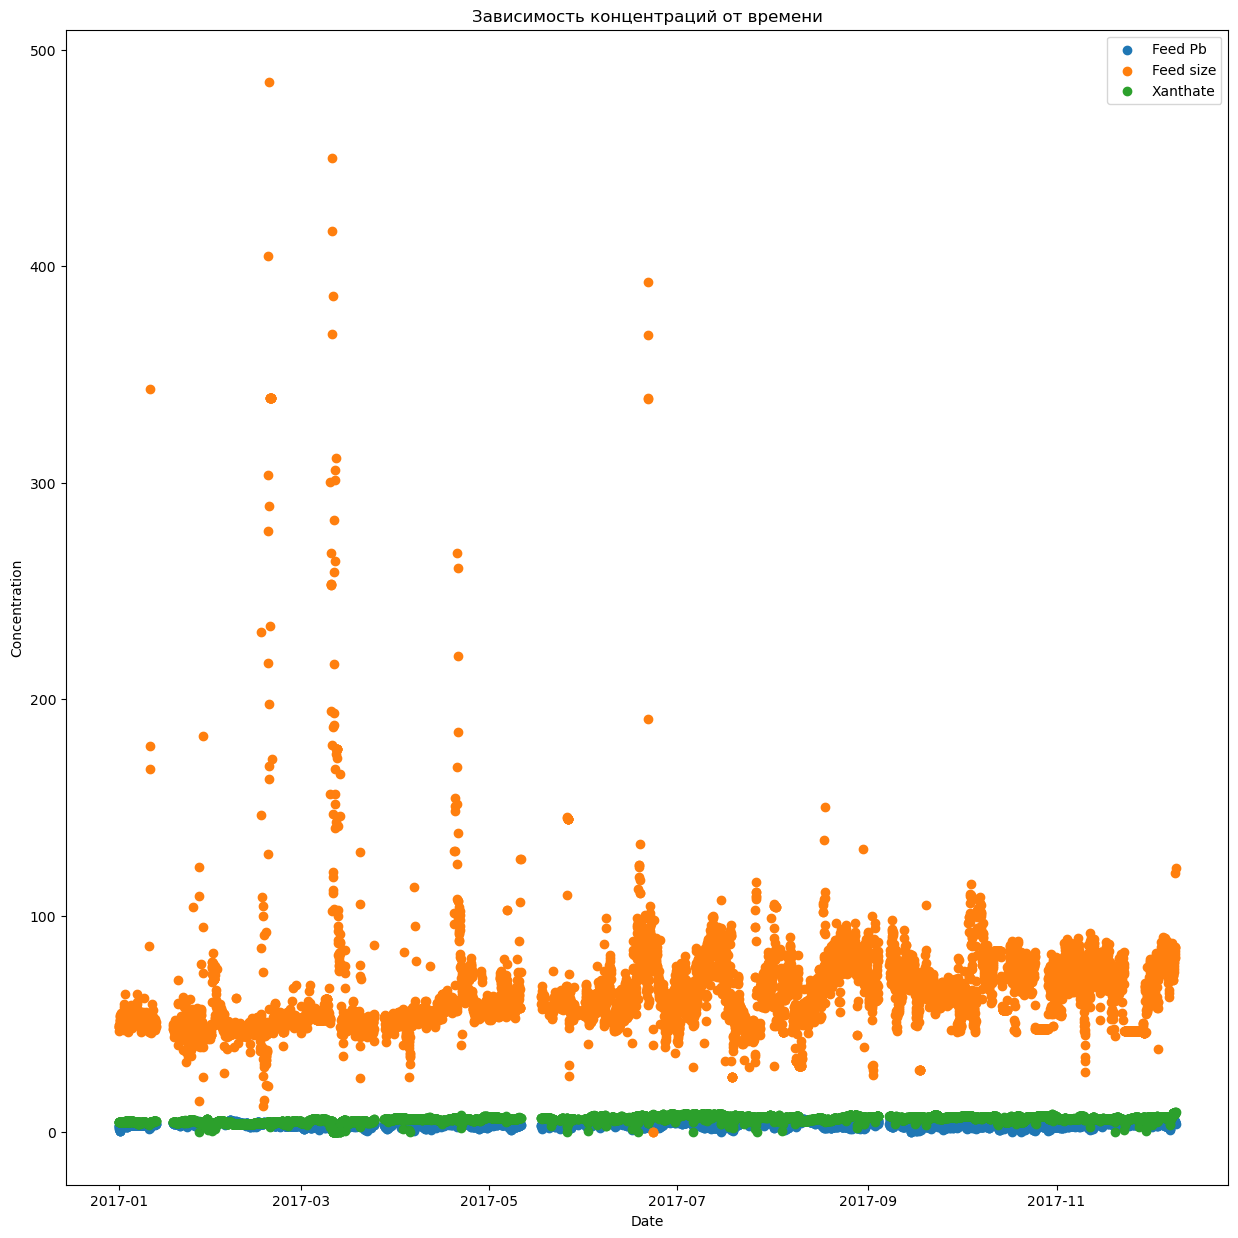

In [19]:
data_train['date'] = pd.to_datetime(data_train['date'])
data_train_slice = data_train[data_train['date'].dt.year == 2017]
#data_train_slice = data_train_slice[data_train_slice['date'].dt.month == 3]
plt.figure(figsize=(15, 15))
plt.scatter(data_train_slice['date'], data_train_slice['rougher.input.feed_pb'], label='Feed Pb')
plt.scatter(data_train_slice['date'], data_train_slice['rougher.input.feed_size'], label='Feed size')
plt.scatter(data_train_slice['date'], data_train_slice['rougher.input.floatbank11_xanthate'], label='Xanthate')
# add labels and legend
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()

# add a blank title
plt.title('Зависимость концентраций от времени')

# display the plot
plt.show()

- feed_pb, feed_size - можно заменить соседними значениями, если они не NaN
- xanthate - тут не очень понятно. Есть один большой провал в данных - то ли этой присадки не было, то ли она не учитывалась. В реальных условиях надо было бы по этому xanthate переговорить с кем-то. В учебной ситуации заменим медианой. 

In [20]:
data_train['rougher.input.feed_size'] = data_train['rougher.input.feed_size'].fillna(method='ffill')
data_train['rougher.input.feed_pb'] = data_train['rougher.input.feed_pb'].fillna(method='ffill')
data_train['rougher.input.floatbank11_xanthate'] = data_train['rougher.input.floatbank11_xanthate'].fillna(data_train['rougher.input.floatbank11_xanthate'].median())

- feed_rate изучим отдельно

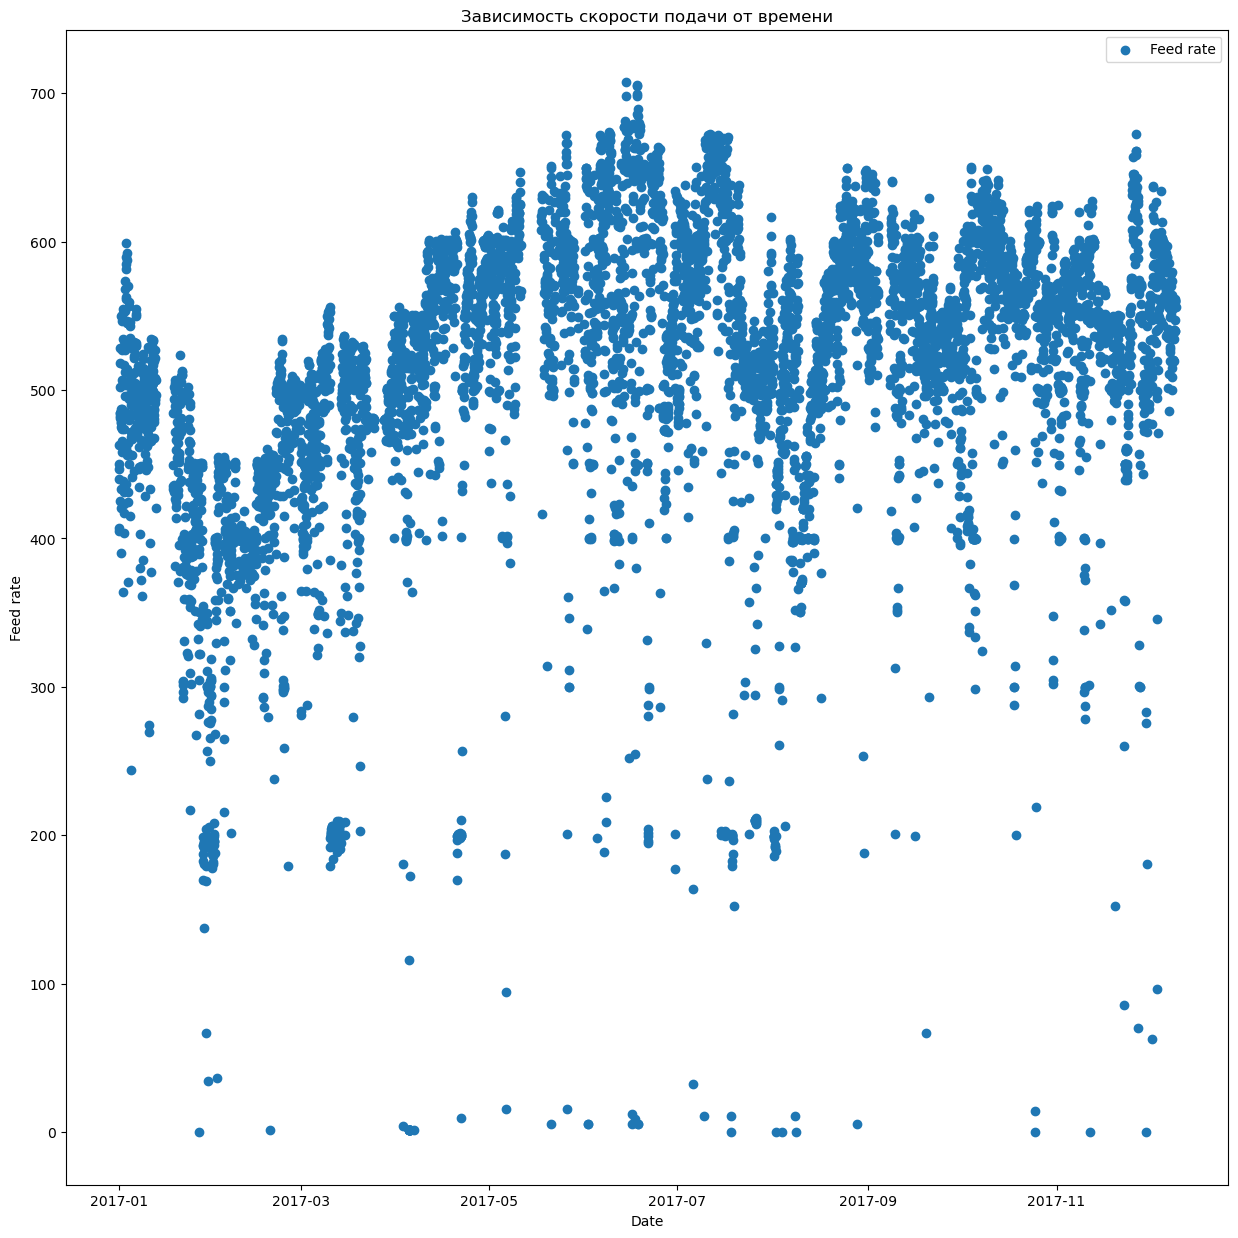

In [21]:
data_train['date'] = pd.to_datetime(data_train['date'])
data_train_slice = data_train[data_train['date'].dt.year == 2017]
#data_train_slice = data_train_slice[data_train_slice['date'].dt.month == 3]
plt.figure(figsize=(15, 15))
plt.scatter(data_train_slice['date'], data_train_slice['rougher.input.feed_rate'], label='Feed rate')
plt.xlabel('Date')
plt.ylabel('Feed rate')
plt.legend()

# add a blank title
plt.title('Зависимость скорости подачи от времени')

# display the plot
plt.show()

Разброс между значениями бывает приличный, параметр очень важный, пропусков в нем совсем мало. Удаляем. 

In [22]:
data_train.dropna(subset=['rougher.input.feed_rate'], inplace=True)
data_train.dropna(subset=['rougher.input.feed_sol'], inplace=True)
data_train.dropna(subset=['rougher.input.floatbank10_sulfate'], inplace=True)
data_train.dropna(subset=['rougher.input.floatbank10_xanthate'], inplace=True)
data_train.dropna(subset=['rougher.input.floatbank11_sulfate'], inplace=True)

In [23]:
data_train[columns_input].filter(regex='rougher').isna().sum()

rougher.input.feed_au                 0
rougher.input.feed_ag                 0
rougher.input.feed_pb                 0
rougher.input.feed_sol                0
rougher.input.feed_rate               0
rougher.input.feed_size               0
rougher.input.floatbank10_sulfate     0
rougher.input.floatbank10_xanthate    0
rougher.input.floatbank11_sulfate     0
rougher.input.floatbank11_xanthate    0
dtype: int64

In [24]:
data_train[columns_input].filter(regex='primary_cleaner').isna().sum()/len(data_train)*100

primary_cleaner.input.sulfate       0.041517
primary_cleaner.input.depressant    0.069195
primary_cleaner.input.feed_size     0.000000
primary_cleaner.input.xanthate      0.332134
dtype: float64

In [25]:
data_train[columns_input].filter(regex='primary_cleaner').boxplot(figsize=(15,15));

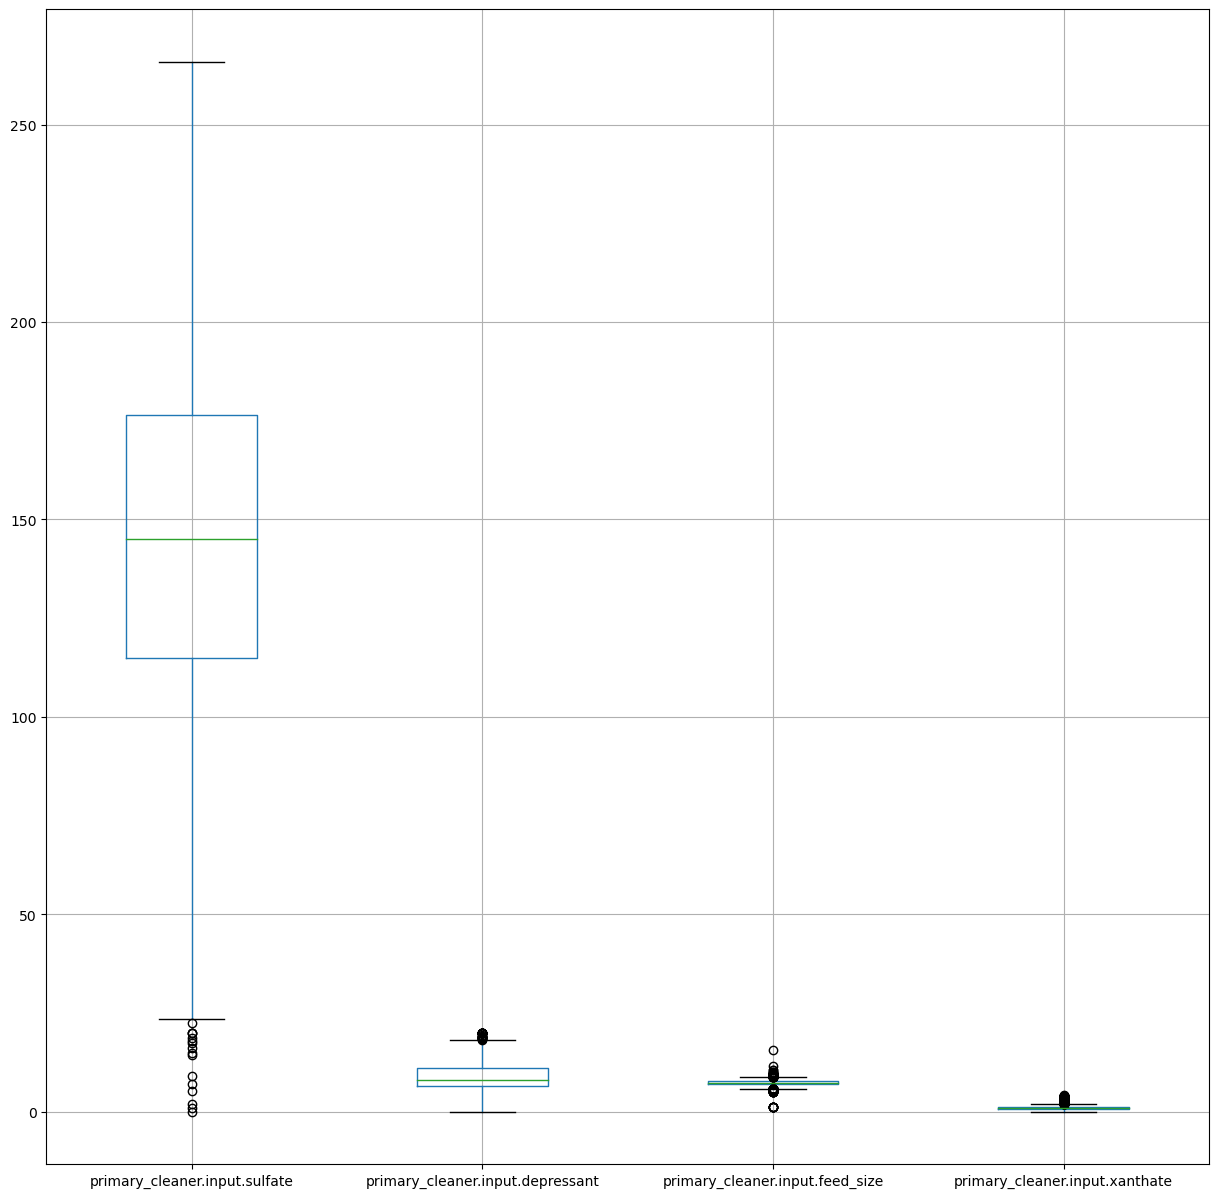

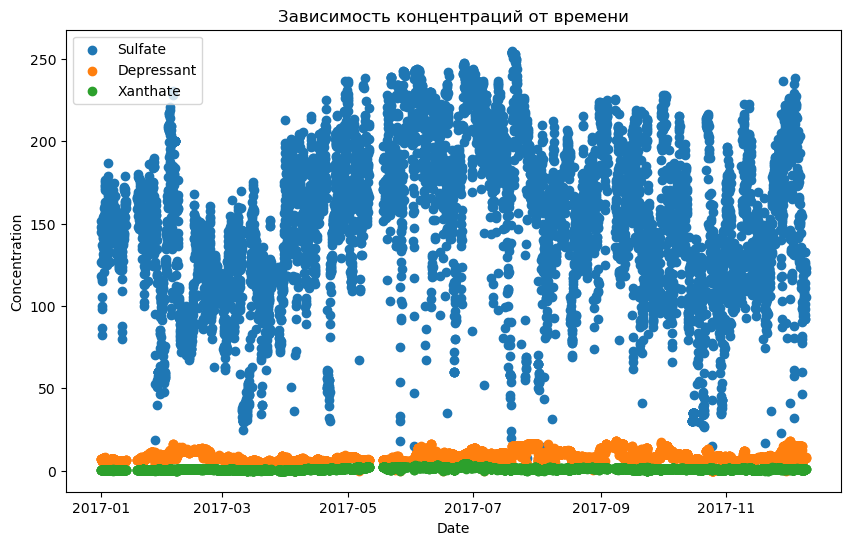

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(data_train_slice['date'], data_train_slice['primary_cleaner.input.sulfate'], label='Sulfate')
plt.scatter(data_train_slice['date'], data_train_slice['primary_cleaner.input.depressant'], label='Depressant')
plt.scatter(data_train_slice['date'], data_train_slice['primary_cleaner.input.xanthate'], label='Xanthate')

plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()

# add a blank title
plt.title('Зависимость концентраций от времени')

# display the plot
plt.show()

Заменим на соседние ненулевые.  

In [27]:
data_train['primary_cleaner.input.sulfate'] = data_train['primary_cleaner.input.sulfate'].fillna(method='ffill')
data_train['primary_cleaner.input.depressant'] = data_train['primary_cleaner.input.depressant'].fillna(method='ffill')
data_train['primary_cleaner.input.xanthate'] = data_train['primary_cleaner.input.xanthate'].fillna(method='ffill')

In [28]:
data_train[columns_input].filter(regex='primary_cleaner').isna().sum()

primary_cleaner.input.sulfate       0
primary_cleaner.input.depressant    0
primary_cleaner.input.feed_size     0
primary_cleaner.input.xanthate      0
dtype: int64

#### Предобработка state

In [29]:
columns_state = []
for col in data_train.columns:
    if 'state' in col:
        columns_state.append(col)
columns_state

['rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rougher.state.floatbank10_c_level',
 'rougher.state.floatbank10_d_air',
 'rougher.state.floatbank10_d_level',
 'rougher.state.floatbank10_e_air',
 'rougher.state.floatbank10_e_level',
 'rougher.state.floatbank10_f_air',
 'rougher.state.floatbank10_f_level',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.state.floatbank8_d_air',
 'primary_cleaner.state.floatbank8_d_level',
 'secondary_cleaner.state.floatbank2_a_air',
 'secondary_cleaner.state.floatbank2_a_level',
 'secondary_cleaner.state.floatbank2_b_air',
 'secondary_cleaner.state.floatbank2_b_level',
 'secondary_cleaner.

In [30]:
data_train[columns_state].isna().sum()*100/len(data_train)

rougher.state.floatbank10_a_air               0.000000
rougher.state.floatbank10_a_level             0.000000
rougher.state.floatbank10_b_air               0.000000
rougher.state.floatbank10_b_level             0.000000
rougher.state.floatbank10_c_air               0.000000
rougher.state.floatbank10_c_level             0.000000
rougher.state.floatbank10_d_air               0.000000
rougher.state.floatbank10_d_level             0.000000
rougher.state.floatbank10_e_air               2.926931
rougher.state.floatbank10_e_level             0.000000
rougher.state.floatbank10_f_air               0.000000
rougher.state.floatbank10_f_level             0.000000
primary_cleaner.state.floatbank8_a_air        0.020758
primary_cleaner.state.floatbank8_a_level      0.000000
primary_cleaner.state.floatbank8_b_air        0.020758
primary_cleaner.state.floatbank8_b_level      0.000000
primary_cleaner.state.floatbank8_c_air        0.000000
primary_cleaner.state.floatbank8_c_level      0.000000
primary_cl

Пропущенные данные - только в параметре air. 

In [31]:
data_train['rougher.state.floatbank10_e_air'].plot.box(figsize=(10, 6));

In [32]:
plt.figure(figsize=(10, 6))
plt.scatter(data_train_slice['date'], data_train_slice['rougher.state.floatbank10_e_air'], label='rougher.state.floatbank10_e_air');

Далеко не всегда соседние параметры близки. Учитывая, что пропущенных значений всего около 3 процентов, лучше их удалить.

In [33]:
data_train.dropna(subset=columns_state, inplace=True)

In [34]:
data_train[columns_state].isna().sum()

rougher.state.floatbank10_a_air               0
rougher.state.floatbank10_a_level             0
rougher.state.floatbank10_b_air               0
rougher.state.floatbank10_b_level             0
rougher.state.floatbank10_c_air               0
rougher.state.floatbank10_c_level             0
rougher.state.floatbank10_d_air               0
rougher.state.floatbank10_d_level             0
rougher.state.floatbank10_e_air               0
rougher.state.floatbank10_e_level             0
rougher.state.floatbank10_f_air               0
rougher.state.floatbank10_f_level             0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
secondary_cleaner.state.floatbank2_a_air

#### Предобработка output

In [35]:
columns_output = []
for col in data_train.columns:
    if 'output' in col:
        columns_output.append(col)
columns_output

['rougher.output.concentrate_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_au',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'secondary_cleaner.output.tail_au',
 'secondary_cleaner.output.tail_ag',
 'secondary_cleaner.output.tail_pb',
 'secondary_cleaner.output.tail_sol',
 'final.output.concentrate_au',
 'final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_au',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'rougher.o

In [36]:
data_train[columns_output].isna().sum()*100/len(data_train)

rougher.output.concentrate_au             0.000000
rougher.output.concentrate_ag             0.000000
rougher.output.concentrate_pb             0.000000
rougher.output.concentrate_sol            0.100604
rougher.output.recovery                   0.000000
rougher.output.tail_au                    0.000000
rougher.output.tail_ag                    0.007186
rougher.output.tail_pb                    0.000000
rougher.output.tail_sol                   0.000000
primary_cleaner.output.concentrate_au     0.000000
primary_cleaner.output.concentrate_ag     0.000000
primary_cleaner.output.concentrate_pb     0.467088
primary_cleaner.output.concentrate_sol    1.444381
primary_cleaner.output.tail_au            0.000000
primary_cleaner.output.tail_ag            0.028744
primary_cleaner.output.tail_pb            0.043116
primary_cleaner.output.tail_sol           0.258695
secondary_cleaner.output.tail_au          0.000000
secondary_cleaner.output.tail_ag          0.007186
secondary_cleaner.output.tail_p

Ничего из output мы для машинного обучения не будем брать, потому что обязательно произойдет утечка признаков. Убедились, что в целевых параметрах - concentrat_au и tail_au - нет пропусков.

#### Предобработка calculations

In [37]:
columns_calculations = []
for col in data_train.columns:
    if 'calcul' in col:
        columns_calculations.append(col)
columns_calculations

['rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.recovery_calculated']

In [38]:
data_train[columns_calculations].isna().sum()

rougher.calculation.sulfate_to_au_concentrate         0
rougher.calculation.floatbank10_sulfate_to_au_feed    0
rougher.calculation.floatbank11_sulfate_to_au_feed    0
rougher.calculation.au_pb_ratio                       0
rougher.output.recovery_calculated                    0
dtype: int64

#### Обработаем признаки в тестовой выборке

In [39]:
pd.set_option('display.max_rows', None)
data_test.isna().sum()/len(data_train)*100

date                                          0.000000
rougher.input.feed_au                         0.000000
rougher.input.feed_ag                         0.000000
rougher.input.feed_pb                         0.201207
rougher.input.feed_sol                        0.158091
rougher.input.feed_rate                       0.028744
rougher.input.feed_size                       0.316183
rougher.input.floatbank10_sulfate             0.021558
rougher.input.floatbank10_xanthate            0.007186
rougher.state.floatbank10_a_air               0.007186
rougher.state.floatbank10_a_level             0.007186
rougher.state.floatbank10_b_air               0.007186
rougher.state.floatbank10_b_level             0.007186
rougher.state.floatbank10_c_air               0.007186
rougher.state.floatbank10_c_level             0.007186
rougher.state.floatbank10_d_air               0.000000
rougher.state.floatbank10_d_level             0.000000
rougher.state.floatbank10_e_air               0.050302
rougher.st

Пропусков в тестовой выборке меньше 1 процента. Удаляем. 

In [40]:
data_test = data_test.dropna()
data_test.isna().sum()

date                                          0
rougher.input.feed_au                         0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_sol                        0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate            0
rougher.state.floatbank10_a_air               0
rougher.state.floatbank10_a_level             0
rougher.state.floatbank10_b_air               0
rougher.state.floatbank10_b_level             0
rougher.state.floatbank10_c_air               0
rougher.state.floatbank10_c_level             0
rougher.state.floatbank10_d_air               0
rougher.state.floatbank10_d_level             0
rougher.state.floatbank10_e_air               0
rougher.state.floatbank10_e_level             0
rougher.state.floatbank10_f_air               0
rougher.state.floatbank10_f_level       

### Вывод по разделу
Проведена предобработка данных датасета data_train, данные готовы для анализа и построения модели.

## Анализ данных

### Изменение концентрации данных на различных этапах очистки

In [41]:
columns_output

['rougher.output.concentrate_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_au',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'secondary_cleaner.output.tail_au',
 'secondary_cleaner.output.tail_ag',
 'secondary_cleaner.output.tail_pb',
 'secondary_cleaner.output.tail_sol',
 'final.output.concentrate_au',
 'final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_au',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'rougher.o

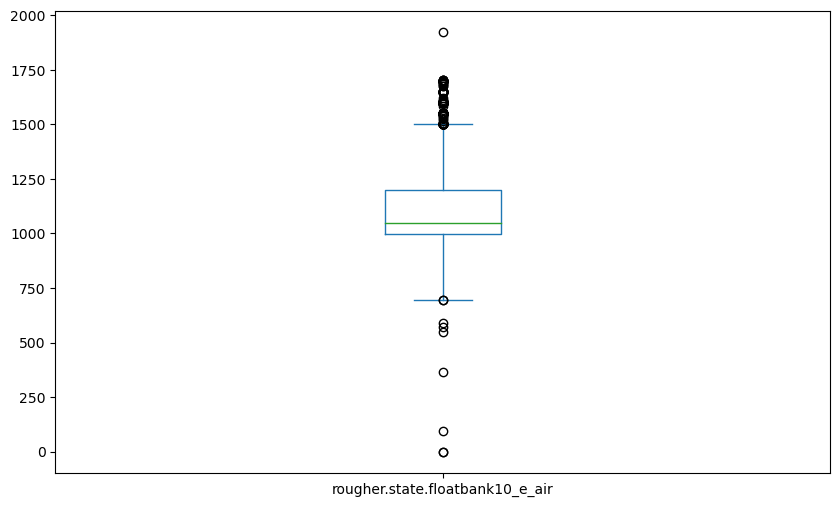

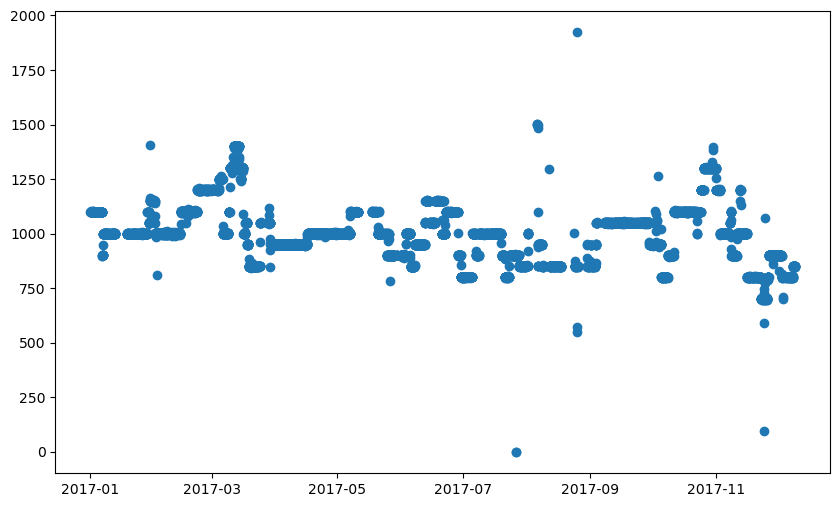

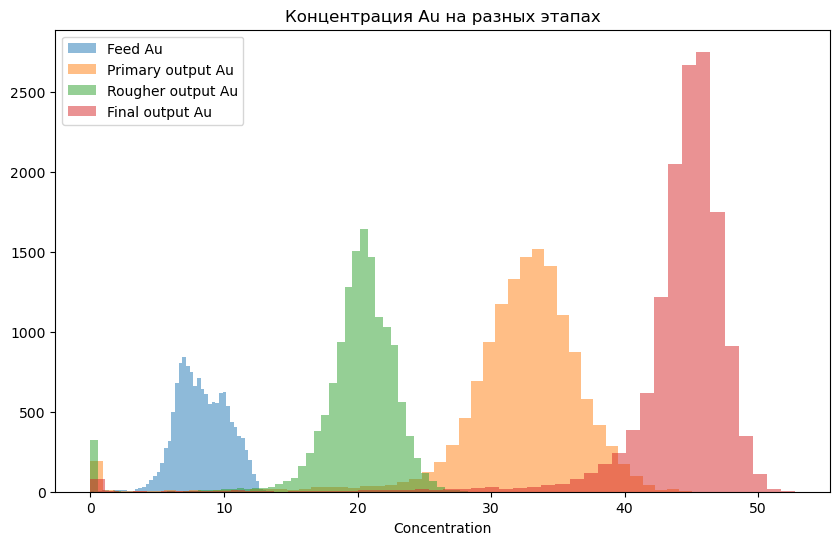

In [42]:
plt.figure(figsize=(10,6))
plt.hist(data_train['rougher.input.feed_au'], bins=50, label='Feed Au', alpha=0.5)
plt.hist(data_train['primary_cleaner.output.concentrate_au'], bins=50, label='Primary output Au', alpha=0.5)
plt.hist(data_train['rougher.output.concentrate_au'], bins=50, label='Rougher output Au', alpha=0.5)
plt.hist(data_train['final.output.concentrate_au'], bins=50, label='Final output Au', alpha=0.5)
plt.legend()
plt.xlabel('Concentration')
plt.title('Концентрация Au на разных этапах')
plt.show()

На всех этапах есть аномалии в районе 0. Надо удалить данные, в которых концентрации меньше 10. 

In [43]:
data_train = data_train[data_train['primary_cleaner.output.concentrate_au'] >= 10]
data_train = data_train[data_train['rougher.output.concentrate_au'] >= 10]
data_train = data_train[data_train['final.output.concentrate_au'] >= 10]

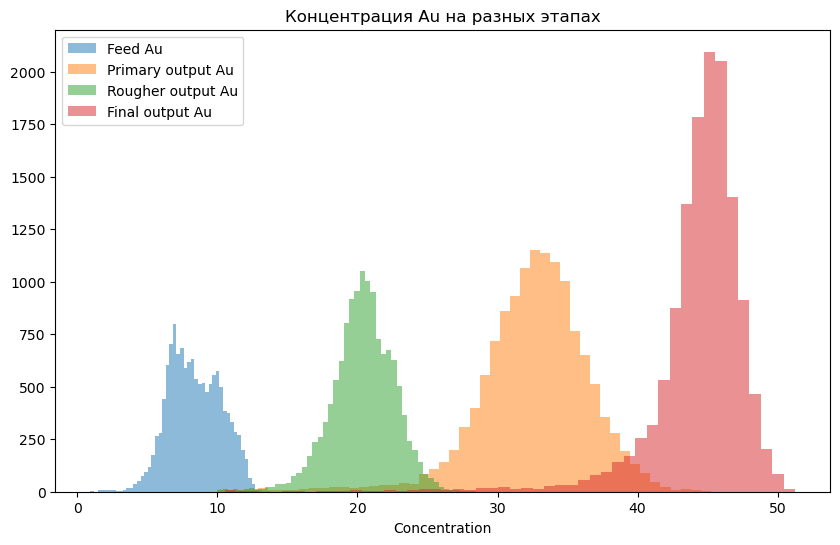

In [44]:
plt.figure(figsize=(10,6))
plt.hist(data_train['rougher.input.feed_au'], bins=50, label='Feed Au', alpha=0.5)
plt.hist(data_train['primary_cleaner.output.concentrate_au'], bins=50, label='Primary output Au', alpha=0.5)
plt.hist(data_train['rougher.output.concentrate_au'], bins=50, label='Rougher output Au', alpha=0.5)
plt.hist(data_train['final.output.concentrate_au'], bins=50, label='Final output Au', alpha=0.5)
plt.legend()
plt.xlabel('Concentration')
plt.title('Концентрация Au на разных этапах')
plt.show()

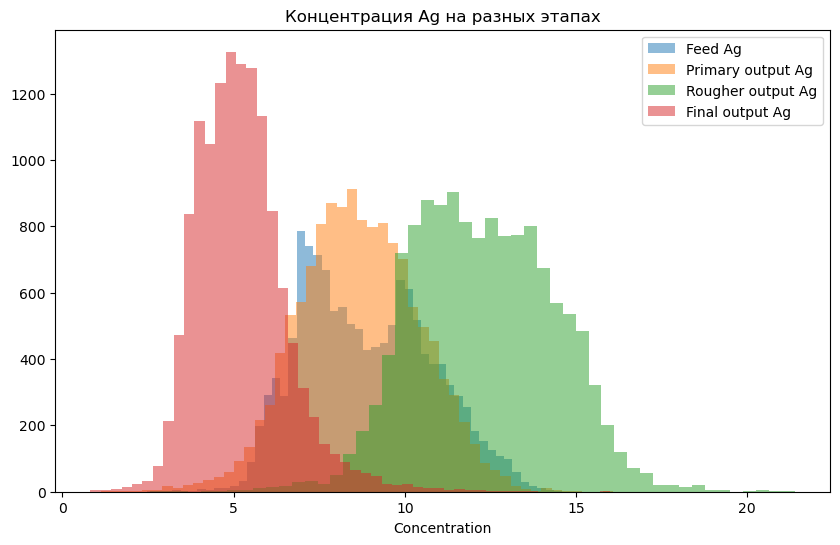

In [45]:
plt.figure(figsize=(10,6))
plt.hist(data_train['rougher.input.feed_ag'], bins=50, label='Feed Ag', alpha=0.5)
plt.hist(data_train['primary_cleaner.output.concentrate_ag'], bins=50, label='Primary output Ag', alpha=0.5)
plt.hist(data_train['rougher.output.concentrate_ag'], bins=50, label='Rougher output Ag', alpha=0.5)
plt.hist(data_train['final.output.concentrate_ag'], bins=50, label='Final output Ag', alpha=0.5)
plt.legend()
plt.xlabel('Concentration')
plt.title('Концентрация Ag на разных этапах')
plt.show()

Концентрация серебра в сырье распределена менее однородно, чем в золоте. На каждом цикле концентрация уменьшается. 

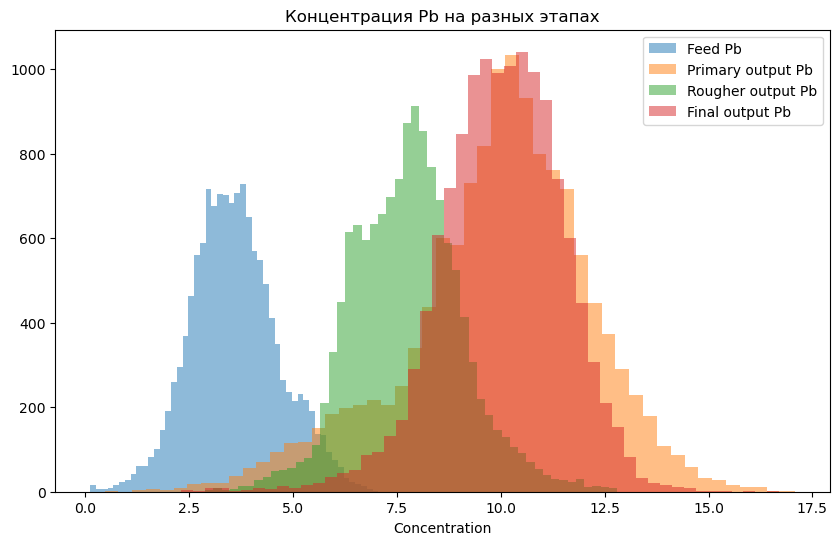

In [46]:
plt.figure(figsize=(10,6))
plt.hist(data_train['rougher.input.feed_pb'], bins=50, label='Feed Pb', alpha=0.5)
plt.hist(data_train['primary_cleaner.output.concentrate_pb'], bins=50, label='Primary output Pb', alpha=0.5)
plt.hist(data_train['rougher.output.concentrate_pb'], bins=50, label='Rougher output Pb', alpha=0.5)
plt.hist(data_train['final.output.concentrate_pb'], bins=50, label='Final output Pb', alpha=0.5)
plt.legend()
plt.xlabel('Concentration')
plt.title('Концентрация Pb на разных этапах')
plt.show()

Приключения концентрации свинца менее очевидны, но аномалий никаких не видно. 

Золота и свинца чем дальше по технологической цепочке, тем больше. А концентрация серебра, наоборот, уменьшается с каждым циклом очистки.

In [47]:
data_train[['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']].mean().sort_values(ascending=False)

final.output.concentrate_pb              10.028898
primary_cleaner.output.concentrate_pb     9.914678
rougher.output.concentrate_pb             7.748993
dtype: float64

### Распределения размеров гранул сырья на обучающей и тестовой выборках

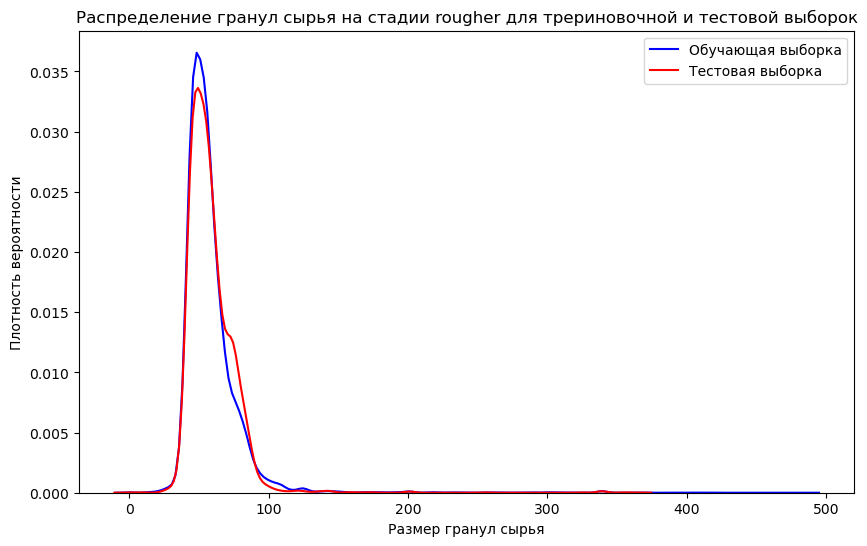

In [48]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.kdeplot(data_train['rougher.input.feed_size'], ax=ax, label='Обучающая выборка', color='blue')

sns.kdeplot(data_test['rougher.input.feed_size'], ax=ax, label='Тестовая выборка', color='red')

ax.set_title('Распределение гранул сырья на стадии rougher для трериновочной и тестовой выборок')
ax.set_xlabel('Размер гранул сырья')
ax.set_ylabel('Плотность вероятности')
ax.legend()

plt.show()

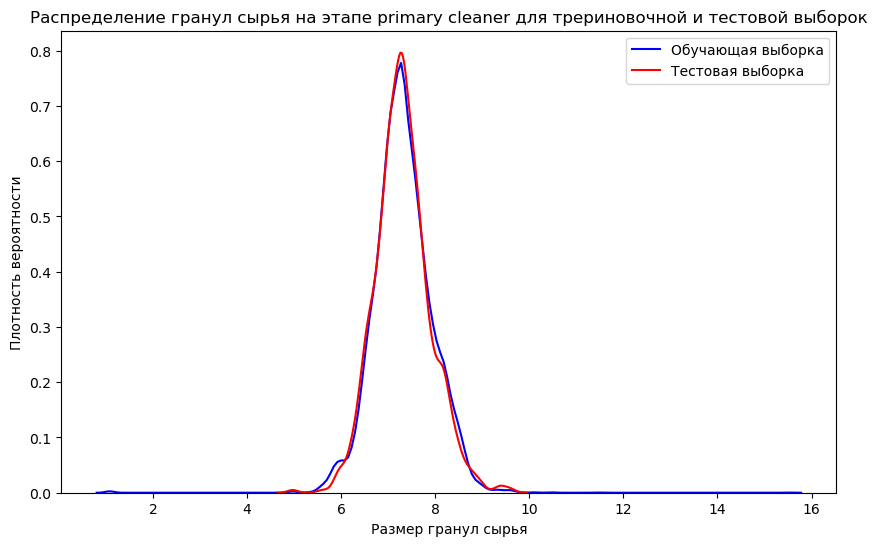

In [49]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.kdeplot(data_train['primary_cleaner.input.feed_size'], ax=ax, label='Обучающая выборка', color='blue')

sns.kdeplot(data_test['primary_cleaner.input.feed_size'], ax=ax, label='Тестовая выборка', color='red')

ax.set_title('Распределение гранул сырья на этапе primary cleaner для трериновочной и тестовой выборок')
ax.set_xlabel('Размер гранул сырья')
ax.set_ylabel('Плотность вероятности')
ax.legend()

plt.show()

### Cуммарная концентрация всех веществ на разных стадиях

In [50]:
data_train['rougher.calculation.input_concentrate'] = (data_train['rougher.input.feed_au'] + 
                                                       data_train['rougher.input.feed_ag'] +
                                                       data_train['rougher.input.feed_pb'] + 
                                                       data_train['rougher.input.feed_sol'])

rougher_output_concentrate_cols = [col for col in data_train.columns if 'rougher.output.concentrate_' in col]
data_train['rougher.calculation.output_concentrate'] = data_train[rougher_output_concentrate_cols].sum(axis=1)

final_output_concentrate_cols = [col for col in data_train.columns if 'final.output.concentrate_' in col]
data_train['final.calculation.output_concentrate'] = data_train[final_output_concentrate_cols].sum(axis=1)


In [51]:
print('Средняя концентрация веществ в сырье:', data_train['rougher.calculation.input_concentrate'].mean())
print('Средняя концентрация веществ в черновом концентрате:', data_train['rougher.calculation.output_concentrate'].mean())
print('Средняя концентрация веществ в финальном концентрате:', data_train['final.calculation.output_concentrate'].mean())

Средняя концентрация веществ в сырье: 57.465108164799226
Средняя концентрация веществ в черновом концентрате: 69.91684220769933
Средняя концентрация веществ в финальном концентрате: 69.23035019701648


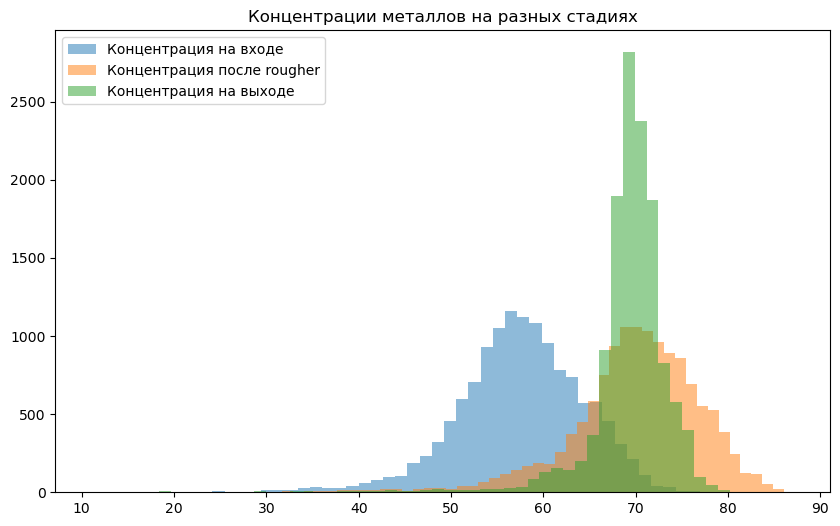

In [52]:
plt.figure(figsize=(10,6))
plt.hist(data_train['rougher.calculation.input_concentrate'], bins=50, label='Концентрация на входе', alpha=0.5)
plt.hist(data_train['rougher.calculation.output_concentrate'], bins=50, label='Концентрация после rougher', alpha=0.5)
plt.hist(data_train['final.calculation.output_concentrate'], bins=50, label='Концентрация на выходе', alpha=0.5)
plt.legend()
plt.title('Концентрации металлов на разных стадиях')
plt.show()

Концентрация веществ в сырье меньше, чем в концентратах. 

## Вывод по разделу

Общая онцентрация веществ в сырье меньше, чем в концентратах. Концентрация золота по мере прохождения технологической цепочки последовательно растет. Обнаружены и устранены аномалии в данных по концентрации золота. Исследование распределение размеров гранул сырья не выявило аномалий. 

## Моделирование

### Функция для вычисления итоговой sMAPE

In [53]:
def get_smape(target, predictions):
    smape = 0
    for i in range(len(target)):
        smape += 2 * abs(target.iloc[i] - predictions[i]) / (abs(target.iloc[i]) + abs(predictions[i]))
    smape = 100 * smape / len(target)
    return smape

def get_total_smape(rougher, final):
    total_smape = 0.25*rougher + 0.75*final
    return total_smape

### Применяем модели

#### Выделим параметры и целевые параметры

Выделим несколько возможных вариантов наборов параметров features

In [54]:
features = data_train.filter(regex='(rougher\.input\.feed)')
print('features', len(features))
target_rougher = data_train['rougher.output.recovery']
print('target_rougher', len(target_rougher))
target_final = data_train['final.output.recovery']
print('target_final', len(target_final))

features 13208
target_rougher 13208
target_final 13208


In [55]:
scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)

#### Кросс-валидация

Напишем функцию, которая для заданного датафрейма, модели, features, target_rougher и target_final посчитает показатель sMAPE на кросс-валидации. 

In [56]:
def crossvalid_score(model, features, target_rougher, target_final):
    
    scorer = make_scorer(get_smape, greater_is_better=False)

    # Cross-validate for target_rougher
    rougher_scores = cross_val_score(model, features, target_rougher, cv=5, scoring=scorer)

    # Cross-validate for target_final
    final_scores = cross_val_score(model, features, target_final, cv=5, scoring=scorer)

    # Calculate total smape
    total_smape = get_total_smape(rougher_scores.mean(), final_scores.mean())
    
    print(-total_smape)
    
    return -total_smape

#### Применим функцию для моделей регрессии в библиотеке sklearn

In [57]:
%%time
model = LinearRegression()
linear_regression_score = crossvalid_score(model, features, target_rougher, target_final)

7.843702756479091
CPU times: total: 1.66 s
Wall time: 858 ms


In [58]:
%%time
model = GradientBoostingRegressor(random_state=12345)
GradientBoostingRegressor_score = crossvalid_score(model, features, target_rougher, target_final)

7.974519741231422
CPU times: total: 18.5 s
Wall time: 41.7 s


In [59]:
%%time
model = SGDRegressor(random_state=12345)
SGDRegressor_score = crossvalid_score(model, features, target_rougher, target_final)

7.860164453602416
CPU times: total: 266 ms
Wall time: 748 ms


In [60]:
%%time
model = SVR()
SVR_score = crossvalid_score(model, features, target_rougher, target_final)

7.833383866668944
CPU times: total: 48.4 s
Wall time: 1min 47s


In [61]:
%%time
model = ElasticNet(random_state=12345)
ElasticNet_score = crossvalid_score(model, features, target_rougher, target_final)

7.760864960894158
CPU times: total: 1.64 s
Wall time: 898 ms


In [62]:
%%time
model = BayesianRidge()
BayesianRidge_score = crossvalid_score(model, features, target_rougher, target_final)

7.839390372779946
CPU times: total: 1.28 s
Wall time: 865 ms


Лучший результат получен для модели ElasticNet. Займемся оптимизацией ее гиперпараметров.

In [65]:
model = ElasticNet(random_state=12345)

scorer =  make_scorer(get_smape, greater_is_better=False)

param_grid = {'alpha': [0.1, 1, 10],
              'l1_ratio': [0.1, 0.5, 0.9]}

grid_search_r = GridSearchCV(model, param_grid, cv=5, scoring=scorer)

grid_search_r.fit(features, target_rougher)

print("Гиперпараметры для target_rougher: ", grid_search_r.best_params_)
print('sMAPE для target_rougher: ', -grid_search_r.best_score_)

grid_search_r.fit(features, target_final)
print("Гиперпараметры для target_final: ", grid_search_r.best_params_)
print('sMAPE для target_final: ', -grid_search_r.best_score_)

Гиперпараметры для target_rougher:  {'alpha': 0.1, 'l1_ratio': 0.1}
sMAPE для target_rougher:  5.939649473241268
Гиперпараметры для target_final:  {'alpha': 0.1, 'l1_ratio': 0.1}
sMAPE для target_final:  8.24966496132982


### Применим к тестовому датасету

#### Применяем оптимизированную модель для получения предсказаний

In [67]:
features_test = data_test.filter(regex='(rougher\.input\.feed)')
features_test = scaler.transform(features_test)

In [68]:
features_test.shape

(4537, 6)

In [69]:
model = ElasticNet(random_state=12345, alpha=0.1, l1_ratio=0.1)
model.fit(features, target_rougher)
predictions_rougher_test = model.predict(features_test)
predictions_rougher_test

array([82.84152429, 83.40707726, 82.93349136, ..., 81.46084788,
       80.37304385, 79.97451611])

In [70]:
model = ElasticNet(random_state=12345, alpha=1, l1_ratio=0.5)
model.fit(features, target_final)
predictions_final_test = model.predict(features_test)
predictions_final_test

array([63.96649556, 63.98187135, 64.06681876, ..., 65.39025999,
       65.05310722, 64.83966221])

#### Считаем sMAPE

In [71]:
# Получим целевые значения из полного датасета
data_test['date'] = pd.to_datetime(data_test['date'])
data_full['date'] = pd.to_datetime(data_full['date'])
data_test_target = pd.merge(data_test, data_full[['date', 'rougher.output.recovery', 'final.output.recovery']], on='date')
#data_test_target.head(10)

In [72]:
# Выделим ответы
target_test_rougher = data_test_target['rougher.output.recovery']
target_test_final = data_test_target['final.output.recovery']

print('features_test', len(features_test))
print('target_test_rougher', len(target_test_rougher))
print('target_test_final', len(target_test_final))

features_test 4537
target_test_rougher 4537
target_test_final 4537


In [73]:
predictions_rougher_test = pd.Series(predictions_rougher_test)
smape_rougher_test = get_smape(target_test_rougher, predictions_rougher_test)
print('Метрика для rougher', smape_rougher_test)

Метрика для rougher 5.281072486272956


In [74]:
predictions_final_test = pd.Series(predictions_final_test)
smape_final_test = get_smape(target_test_final, predictions_final_test)
print('Метрика для final', smape_final_test)

Метрика для final 8.477384394230823


In [75]:
total_smape = get_total_smape(smape_rougher_test, smape_final_test)
print('Общяя метрика', total_smape)

Общяя метрика 7.678306417241355


#### Предсказание средним

In [76]:
prediction_rougher_test_mean = pd.Series(target_rougher.mean(), index=predictions_rougher_test.index)

In [77]:
prediction_final_test_mean = pd.Series(target_final.mean(), index=predictions_rougher_test.index)

In [78]:
mean_rougher_smape = get_smape(target_test_rougher, prediction_rougher_test_mean)
mean_rougher_smape

6.101002010498827

In [79]:
mean_final_smape = get_smape(target_test_final, prediction_final_test_mean)
mean_final_smape

9.139861304354449

In [80]:
total_smape_rougher = get_total_smape(mean_rougher_smape, mean_final_smape)
total_smape_rougher

8.380146480890543

In [83]:
print('Эффективность предсказания повышается на', total_smape_rougher - total_smape)

Эффективность предсказания повышается на 0.7018400636491879


# Общий вывод

Исследованы модели, которые на основе качества входного сырья определяет эффективность очистки золота. Модель ElasticNet из библиотеки sklearn позволяет получать показатели с низкой метрикой ошибки при сравнительно быстрой работе. Для данной модели проведена оптимизаци гиперпараметров, получены оптимальные гиперпараметры для предсказания эффективности очистки золота на разничных этапах. Метрика ошибки для предсказаний, полученных на тестовой выборке для оптимизированной модели, оказалась на 1,5 процента ниже, чем метрика для референсной модели, предсказывающей средним значением. 